<a href="https://colab.research.google.com/github/namhawon/2024_Study03/blob/main/03_dot_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 6. 좌표평면 위의 점이 어떤 소용돌이 그래프에 속할지 분류하기  
  
책의 실습 6 시작 부분에는 빨간색, 노란색, 파란색 점들로 이루어지는 소용돌이 3개와 초록색 별 모양으로 이루어진 그림이 있다. 이 그림을 보면, 우리는 쉽게 이 점은 노란색 소용돌이에 속할 것이라고 답할 수 있을 것이다. 이번 실습에서는 신경망을 이용하여, 좌표평면 위의 새로운 점이 순서쌍으로 주어질 때, 그 점이 어느 소용돌이에 속하는 것이 가장 적절할지 예상하는 모델을 학습시켜볼 것이다. 앞선 실습 5에서 1차원 입력 데이터를 다루었다면, 이번에는 2개의 숫자로 구성되는 2차원 입력 데이터를 다루어보는 것이다. 신경망의 기본적인 원리를 앞선 이론 부분에서 충분히 이해하고, 설명을 천천히 따라가다 보면 어렵지 않게 구현할 수 있을 것이다. 덧붙여, 실습 5의 내용이 잘 기억나지 않는다면 다시 한 번 읽어보는 것을 추천한다.

## Step 1. 필요한 라이브러리 import 하기, 데이터 가져오기  
  
이번 실습을 진행하는 데 필요한 라이브러리를 import 하고, 실습 1(셋업) 과정에서 다운로드한 클래스인 ToyData의 객체 data를 생성하여 데이터셋을 구축하자. ToyData 클래스는 객체 생성 시, 우선 입력받은 개수만큼의 소용돌이를 표현하는 데이터를 만든다. 이 데이터는 특정 소용돌이에 속한 있는 점의 좌표와 그 점이 속한 소용돌이 정보이다. 본 실습에서는 교재에 나와있는 그림처럼 3개의 소용돌이를 사용할 것이지만, 다른 숫자를 사용해보는것도 좋다. 생성된 소용돌이의 모양을 교재에 나와있는 그림처럼 출력하려면, 메서드 load_data()를 사용하면 된다. 이제, 모델을 학습시키는 데 사용할 학습용 데이터셋 xtrain과 ytrain, 모델 파라미터를 평가하는 데 사용할 테스트용 데이터셋 xtest, ytest로 나누어 저장해주자. 아래 코드를 그대로 시행하고, 우선 위의 그림처럼 소용돌이가 잘 나타나는지 확인해보자.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
%ls

'Colab Notebooks'/   실습_3-1_Universal_Approximator_정답포함.ipynb
 OUTTA3회실습/       실습_3-2_dot_classification_정답포함.ipynb
 __pycache__/        실습_3-3_dot_classification_withNN_정답포함.ipynb
 toydata.py


In [ ]:
# Please Do NOT Modiify this Cell
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import toydata

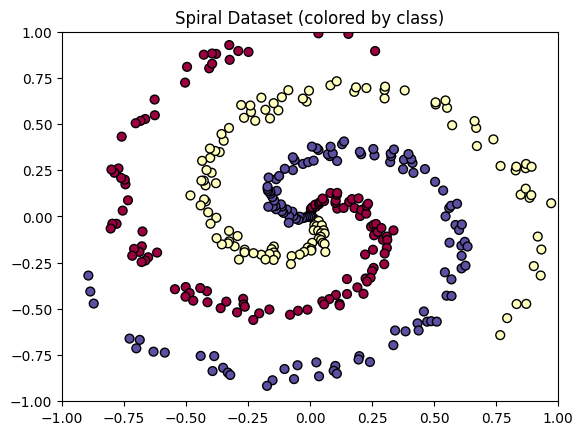

In [ ]:
# 사용할 소용돌이 데이터셋 구축
num_tendril = 3 # 데이터에 포함된 소용돌이의 개수 지정.
data = toydata.ToyData(num_classes=num_tendril)

# 데이터셋 분류하기
xtrain, ytrain, xtest, ytest = data.load_data()

# 소용돌이 형태를 좌표평면 위에 나타내기
fig, ax = data.plot_spiraldata()

좌표평면에 그래프를 나타내어 소용돌이 데이터의 형태를 확인했다면, 이제 학습에 사용될 데이터가 어떻게 구성되는지도 살펴보자. 이를 위해 xtrain과 ytrain의 type()을 확인하고, 각각이 어떤 정보를 저장하고 있는지 확인해보자.

In [ ]:
# xtrain, ytrain의 type() 확인하기
print(type(xtrain))
print(type(ytrain))

# xtrain, ytrain 출력하기
print(f"xtrain: {xtrain} \n")
print(f"ytrain: {ytrain}")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
xtrain: [[ 4.68333811e-03  2.47712471e-02]
 [ 3.09410781e-01 -1.69801190e-01]
 [ 5.92658162e-01  6.88037798e-02]
 [ 5.69929719e-01 -3.40437323e-01]
 [-3.96985441e-01  2.36679971e-01]
 [ 5.82787097e-02 -1.48647711e-01]
 [-3.86634260e-01 -7.55561173e-01]
 [-1.36702746e-01  2.01744452e-01]
 [-1.40242409e-02  6.21690571e-01]
 [ 1.03356957e-01  8.59951079e-02]
 [-7.00715303e-01 -7.13441014e-01]
 [-4.17564139e-02 -2.05892459e-01]
 [ 3.41496281e-02 -1.21336356e-01]
 [ 2.28068113e-01  5.78641035e-02]
 [ 1.48693606e-01 -3.38531703e-01]
 [ 7.74632171e-02 -4.47120905e-01]
 [-7.03217685e-01  5.04633665e-01]
 [-3.26284349e-01 -1.34558529e-01]
 [-4.84852456e-02 -5.10306895e-01]
 [-6.31456017e-01 -7.31550574e-01]
 [-3.30743313e-01 -1.45529151e-01]
 [-3.37852478e-01 -4.60853904e-01]
 [-7.55638599e-01  3.16823162e-02]
 [-4.82538402e-01  1.13897547e-01]
 [-1.38385549e-01 -2.10723206e-01]
 [ 7.66629279e-01 -6.42089963e-01]
 [-8.94125283e-01 -3.19752812e-01]

위의 코드를 적절히 완성하면, xtrain과 ytrain은 둘 다 numpy의 ndarray 형태임을 확인해볼 수 있다. xtrain은 점들의 순서쌍으로 구성된 배열이며, ytrain은 xtrain의 점이 속하는 소용돌이의 종류를 숫자 0, 1, 2(소용돌이가 3개이므로)로 표현하는 배열이다. 예를 들어, 학습에 사용되는 데이터가 3개이고 그래프 상에서 빨간색 소용돌이(0으로 표현)에 속하는 점 좌표가 (1.1, 2.1), 노란색 소용돌이(1로 표현)에 속하는 점이 (0, -4.7), 파란색 소용돌이(2로 표현)에 속하는 점이 (-2.9, 1.3)이라면, xtrain은 [[1.1, 2.1], [-2.9, 1.3], [0, -4.7]], ytrain은 [0, 2, 1]로 구성되게 된다.

## Step 2. 학습의 큰 틀 구상하기  
  
이번 실습에서 우리가 궁극적으로 얻어야 하는 결과는 한 점이 어떤 소용돌이에 속하는지 분류된 결과이기에, 모델을 통해 얻게 될 결과는 0, 1, 2의 숫자 중 하나일 것이라고 생각하기 쉽다. 하지만 딥러닝에서 분류(classification) 문제를 해결할 때는 보통 분류할 카테고리의 개수만큼의 출력을 벡터의 형태로 얻도록 한다. 우리에게 주어진 새로운 점이 각 카테고리에 포함될 가능성의 척도를 숫자로 나타내는 것이다. 이 가능성을 0 이상이고 총합이 1이도록 조절한다면, 이를 확률과 비슷한 의미로 생각할 수 있다. 가령, 출력 결과가 [1, 0, 0]이면 이 점이 0번 소용돌이에 속한다고 확신할 수 있을 것이고, 출력 결과가 [0.2, 0.3, 0.5]이면 2번 소용돌이에 속할 가능성이 가장 높다고 판단하는 것이다. 이와 같은 결과를 얻기 위해, 우리는 2개의 층으로 된 신경망(입력층을 제외하고 1개의 은닉층과 출력층을 가짐)을 구축할 것이다. 은닉층, 그리고 출력층으로 전달되는 과정의 가중치 곱 계산에 걸쳐 한 점이 각 소용돌이에 포함될 가능성의 척도를 구할 것이고, 이후 출력층의 활성함수를 통해 이 척도가 확률과 같은 성질을 갖도록 가공할 것이다. 책에 나오는 그림 2.4-27과 2.4-28을 통해 전체적인 구조를 살펴본 후, 세부적인 구조를 파헤쳐보자.

우선, 출력 결과를 얻기 위한 신경망의 수학적 구조를 설계해보자. 입력 데이터를 2차원 벡터인 $x$, 원하는 결과를 $\mathbf{y_{pred}} = [y_0, y_1, y_2]$이라고 하고, 모델 파라미터는 벡터인 $\mathbf{v_i}$, $\mathbf{w_i}$와 스칼라인 $b_i$ 이라고 할 때,  
  
$ \mathbf{y_{pred}} = F(\{\mathbf{v_i}\}, \{\mathbf{w_i}\}, \{b_i\}; \mathbf{x}) = \sum \limits_{i=1}^N \mathbf{v_i} \varphi (\mathbf{x} \cdot \mathbf{w_i} + b_i) $  
  
으로 근사식을 표현할 수 있다. 실습 5에서와 마찬가지로, $N$은 뉴런의 개수이다. 이때, $\mathbf{w_i}$는 $\mathbf{x}$와 동일하게 2차원 벡터이며, $\mathbf{v_i}$는 우리가 원하는 결과와 동일한 차원을 가져야 하므로 3차원 벡터이어야 할 것이다.

이번에도 학습을 진행할 때는 데이터를 batch로 나눌 것이다. 모델을 클래스로 구현할 때 하나의 batch에 대한 순전파를 동시에 진행시켜주기 위해, 위의 근사식을 바탕으로 하는 계산 과정을 구상해보자. 하나의 batch에 포함되는 데이터의 개수를 $M$개라고 할 때, 입력 데이터 $\mathbf{x}$는 이제 $M$개의 데이터를 모은 shape-($M$, 2)의 행렬 $X$가 될 것이다. 하나의 batch에 속하는 입력 데이터를 $\mathbf{x_1}$, $\mathbf{x_2}$, ..., $\mathbf{x_M}$이라고 하면, 이들 각각을 행벡터로 두었을 때 $X$는  
  
$X = \begin{pmatrix} \mathbf{x_1} \\ \mathbf{x_2} \\ \vdots \\ \mathbf{x_M} \end{pmatrix}$  
  
로 표현되는 것이다.

아래의 Step 3에서는 순전파 과정에서 이루어지는 연산을 행렬곱으로 표현하여 코드로 작성하게 될 것이다. 실습 5에서 진행했던 과정과 크게 다르지 않으나, 아직 낯설 수 있으니 한 번만 더 따라가보자. 우선 shape-($M$, 2)의 행렬 $X$와 2차원 열벡터 $\mathbf{w_i}$ $N$개를 열에 대해 늘어놓은 shape-(2, $N$)의 행렬 $W = \begin{pmatrix} \mathbf{w_1} & \mathbf{w_2}& \cdots & \mathbf{w_N} \end{pmatrix}$를 행렬곱하면, shape-($M$, $N$)인 아래의 행렬을 얻게 된다.  
  
$ XW = \begin{pmatrix} \mathbf{x_1} \\ \mathbf{x_2} \\ \vdots \\ \mathbf{x_M} \end{pmatrix} \begin{pmatrix} \mathbf{w_1} & \mathbf{w_2}& \cdots & \mathbf{w_N} \end{pmatrix} = \begin{pmatrix} \mathbf{x_1} \cdot \mathbf{w_1} & \mathbf{x_1} \cdot \mathbf{w_2} & \cdots & \mathbf{x_1} \cdot \mathbf{w_N} \\ \mathbf{x_2} \cdot \mathbf{w_1} & \mathbf{x_2} \cdot \mathbf{w_2} & \cdots & \mathbf{x_2} \cdot \mathbf{w_N} \\ \vdots & \vdots & \ddots & \vdots \\ \mathbf{x_M} \cdot \mathbf{w_1} & \mathbf{x_M} \cdot \mathbf{w_2} & \cdots & \mathbf{x_M} \cdot \mathbf{w_N} \end{pmatrix}
$

다음으로, $XW$의 계산 결과로 얻은 행렬의 각 $j$번째 열의 원소 전부에 $b_j$를 더하고, 그 직후 행렬의 모든 원소에 대한 활성함수값을 구해야 한다. 그 결과는 아래와 같을 것이다.  
  
$
\begin{pmatrix} \varphi(\mathbf{x_1} \cdot \mathbf{w_1}+b_1) & \varphi(\mathbf{x_1} \cdot \mathbf{w_2}+b_2) & \cdots & \varphi(\mathbf{x_1} \cdot \mathbf{w_N}+b_N) \\ \varphi(\mathbf{x_2} \cdot \mathbf{w_1}+b_1) & \varphi(\mathbf{x_2} \cdot \mathbf{w_2}+b_2) & \cdots & \varphi(\mathbf{x_2} \cdot \mathbf{w_N}+b_N) \\ \vdots & \vdots & \ddots & \vdots \\ \varphi(\mathbf{x_M} \cdot \mathbf{w_1}+b_1) & \varphi(\mathbf{x_M} \cdot \mathbf{w_2}+b_2) & \cdots & \varphi(\mathbf{x_M} \cdot \mathbf{w_N}+b_N) \end{pmatrix}
$
  
이때 사용하는 활성함수 $\varphi$로는, 분류 문제에 주로 사용되는 ReLU 함수를 사용할 것이다. ReLU 함수가 무엇인지 기억이 나지 않는다면, 4절의 더 알아보기 1을 다시 읽어보자.

마지막으로, 우리가 원하는 결과였던 3차원 벡터 $\mathbf{y_{pred}}$ 또한 $M$개의 batch에 대해 동시에 계산하는 상황으로 확장하면, $\mathbf{x_1}$, $\mathbf{x_2}$, ..., $\mathbf{x_M}$에 대해 얻은 결과 $\mathbf{y_1}$, $\mathbf{y_2}$, ..., $\mathbf{y_M}$을 행벡터로 가지는 shape-($M$, 3)의 행렬 $Y$로 확장해야 할 것이다. 이때, $\mathbf{y_j} = F(\{\mathbf{v_i}\}, \{\mathbf{w_i}\}, \{b_i\}; \mathbf{x_j}) = \sum \limits_{i=1}^N \mathbf{v_i} \varphi (\mathbf{x_j} \cdot \mathbf{w_i} + b_i) $이므로, 우리가 구하고자 하는 결과는 다음과 같다.  

$
Y = \begin{pmatrix} \mathbf{y_1} \\ \mathbf{y_2} \\ \vdots \\ \mathbf{v_M} \end{pmatrix}
= \begin{pmatrix} \sum \limits_{i=1}^N \mathbf{v_i} \varphi (\mathbf{x_1} \cdot \mathbf{w_i} + b_i) \\ \sum \limits_{i=1}^N \mathbf{v_i} \varphi (\mathbf{x_2} \cdot \mathbf{w_i} + b_i) \\ \vdots \\ \sum \limits_{i=1}^N \mathbf{v_i} \varphi (\mathbf{x_M} \cdot \mathbf{w_i} + b_i) \end{pmatrix}
$  
  
이 결과는 앞 단계에서 구했던 행렬과 $\mathbf{v_i}$를 행벡터로 갖는 shape-($N$, 3) 행렬의 곱으로써 구할 수 있다.  
  
$
Y = \begin{pmatrix} \varphi(\mathbf{x_1} \cdot \mathbf{w_1}+b_1) & \varphi(\mathbf{x_1} \cdot \mathbf{w_2}+b_2) & \cdots & \varphi(\mathbf{x_1} \cdot \mathbf{w_N}+b_N) \\ \varphi(\mathbf{x_2} \cdot \mathbf{w_1}+b_1) & \varphi(\mathbf{x_2} \cdot \mathbf{w_2}+b_2) & \cdots & \varphi(\mathbf{x_2} \cdot \mathbf{w_N}+b_N) \\ \vdots & \vdots & \ddots & \vdots \\ \varphi(\mathbf{x_M} \cdot \mathbf{w_1}+b_1) & \varphi(\mathbf{x_M} \cdot \mathbf{w_2}+b_2) & \cdots & \varphi(\mathbf{x_M} \cdot \mathbf{w_N}+b_N) \end{pmatrix}
\begin{pmatrix}
\mathbf{v_1} \\ \mathbf{v_2}\\ \vdots \\ \mathbf{v_N}
\end{pmatrix}
$  
  
이로써 은닉층에서부터 출력층의 가중치 곱까지의 계산과정 설계가 완료되었다. 이러한 수학적 과정을 코드로 구현하는 방법은 Step 3에서 고민해보자. 이때까지 한 작업을 요약하면, 우리는 입력 데이터가 주어졌을 때 이 데이터가 세 개의 소용돌이에 속하게 될 가능성을 각각 벡터로 나타낸 것이다.

다음 단계인 출력층의 활성함수로는 4절의 더 알아보기 1에서 설명한 ‘소프트맥스 함수’를 이용하여 가능성의 척도를 0 이상의 총합이 1인 확률값으로 가공해줄 것이다. 가령, 하나의 입력 데이터 $\mathbf{x_j}$에 대해 계산된 가능성의 척도 $\mathbf{y_j} = (y_{j0}, y_{j1}, y_{j2})$가 주어졌을 때, 소프트맥스 함수를 거치면  
  
$\left( \frac{e^{y_{j0}}}{e^{y_{j0}}+e^{y_{j1}}+e^{y_{j2}}}, \frac{e^{y_{j1}}}{e^{y_{j0}}+e^{y_{j1}}+e^{y_{j2}}}, \frac{e^{y_{j2}}}{e^{y_{j0}}+e^{y_{j1}}+e^{y_{j2}}} \right) = (p_{j0}, p_{j1}, p_{j2}) = \mathbf{p_j}$  
  
의 결과를 얻을 수 있을 것이다. 이 세 값은 전부 0 이상 1 이하의 값을 가지며, 총합이 1이므로 확률과 유사한 성질을 가짐을 확인할 수 있다.

마지막으로, 우리 모델의 성능을 평가하기 위한 손실함수를 결정하자. 소프트맥스 함수와 주로 함께 사용되는 손실함수는 ‘교차 엔트로피 함수’이고, 더 알아보기 1에서 설명했듯 분류 문제를 모델이 잘 해결했는지 평가해줄 것이다. 따라서 이번 실습에서는 교차 엔트로피 함숫값을 소용돌이의 총 개수인 3으로 나눈 평균값을 손실함수로 사용할 것이다. 교차 엔트로피 함숫값 계산에 필요한 정답 레이블 $\mathbf{t_j}$는 제공된 데이터셋의 정답으로부터 쉽게 생성할 수 있다. 3차원 벡터로, 점이 속하는 소용돌이가 0번 소용돌이라면 (1, 0, 0), 1번 소용돌이라면 (0, 1, 0) 등으로 생성하면 된다.  
$ ℒ( \mathbf{p_j}, \mathbf{t_j}) = ℒ((p_{j0}, p_{j1}, p_{j2}), (t_{j0}, t_{j1}, t_{j2})) = - \frac{1}{3} \sum \limits_{i=0}^2 t_{ji} \log p_{ji}$

손실함수를 통한 학습은 이전의 실습들에서처럼 경사하강법을 사용하여 진행할 것이다. Step 3로 넘어가기 전, 책의 그림 2.4-27과 그림 2.4-28을 다시 확인하고, 신경망의 전체 틀을 다시 한 번 확인해보자. 완료했다면, 이제 이 신경망을 구현하고, 학습에 필요한 요소들을 하나씩 구현해보자.

## Step 3. 모델(클래스) 정의하기  
  
이번 단계에서는 Step 2에서 설계한 은닉층부터 출력층의 가중치 곱 단계까지를 계산하는, 즉 순전파 단계를 진행할 수 있게 하는 모델을 클래스의 형태로 설계해볼 것이다. 출력층의 활성함수인 소프트맥스 함수는 추후 Step 4에서 교차 엔트로피 함수와 결합한 형태로 사용할 것이다. 클래스의 객체를 생성할 때는 은닉층에 사용할 뉴런의 개수 num_neurons(Step 2의 설명에서 $N$), 그리고 분류의 결과 개수인 num_classes(이번 실습에서는 3으로 사용)을 입력받게 할 것이다. ReLU 함수는 더 알아보기 1에서 설명했듯, 아래 코드를 통해 torch 라이브러리에서 가져와 사용할 수 있다.

```python
import torch.nn.functional as F
# torch.nn.functional.relu 사용
x = torch.randn(10, 5, requires_grad=True)  # 예시로 랜덤 tensor를 생성했습니다.

# relu 활성화 함수 적용
output = F.relu(x)
```

모델 파라미터 , $\mathbf{v_i}$, $\mathbf{w_i}$(벡터)와 $b_i$(스칼라)를 초기화하기 위해 $\mathbf{v_i}$, $\mathbf{w_i}$는 He Normal이라는 초기화 방법을 사용할 것이고, $b_i$는 전부 0으로 초기화할 것이다. He Normal 초기화 방법은 뉴런 개수가 $N$개일 때, 평균이 0이고 표준편차가 $\sqrt \frac{2}{N}$인 정규분포로부터 값을 랜덤하게 추출하는 방법으로, 활성함수로 ReLU를 사용할 때 적합한 초기화 방법으로 알려져 있다.
  클래스의 기본적인 구성은 이때까지의 실습에서 다루었던 것과 유사한 구조를 가지므로, 주석을 보면 전반적으로 쉽게 작성할 수 있을 것이다.


  참고 : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
  
  
  아래 코드를 완성해보자.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def initialize_params(self, N, num_classes: int):
        """
        self.w, self.b, self.v를 초기화
        w, v는 He 초기화를 이용하고, b는 전부 0으로 초기화

        self.w : shape-(2, self.N), torch.nn.init.kaiming_normal_ 이용
        self.b : shape-(self.N,), torch.zeros를 활용
        self.v : shape-(self.N, self.num_classes), torch.nn.init.kaiming_normal_ 이용
        """
        self.w = nn.Parameter(torch.empty(2, N))
        self.b = nn.Parameter(torch.zeros(1, N))
        self.v = nn.Parameter(torch.empty(N, num_classes))

        nn.init.kaiming_normal_(self.w, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.v, mode='fan_in', nonlinearity='relu')

    def __init__(self, num_neurons, num_classes):
        """
        매개변수 (Parameters)
        ----------
        num_neurons : int형
            신경망의 은닉층에 사용하게 될 뉴런의 개수, N

        num_classes : int
            분류 결과의 가짓수. 본 실습에서는 주어진 소용돌이의 총 개수로, 3을 사용
        """
        super(Model, self).__init__()
        # 파라미터 초기화
        self.initialize_params(num_neurons, num_classes)

    def forward(self, x):
        """
        설계한 모델에서, 입력된 데이터 x(위의 이론 설명에서의 행렬 )에 대해 순전파를 진행하게 하는 함수.
        즉, 은닉층에서 일어나는 연산과 출력층의 가중치 곱 연산을 수행하여 반환

        매개변수 (Parameters)
        ----------
        x : array_like, shape-(M, 2)
            학습용 데이터인 점의 좌표 순서쌍을 batch 단위로 묶어놓은 것

        반환 값 (Returns)
        -------
        prediction : torch.Tensor형, shape-(M, num_classes)
            출력층의 활성함수로 전달하게 될 shape-(M, num_classes)인 행렬
        """
        # 은닉층부터 출력층의 가중치 곱까지의 행렬 연산
        out1 = F.relu(x @ self.w + self.b)
        return out1 @ self.v

    @property
    def model_parameters(self):
        """
        모델 파라미터들에 대한 getter를 데코레이터를 이용하여 구현
        이전의 실습들에서와 유사한 형태임을 참고

        반환 값 (Returns)
        -------
        Tuple[Tensor, ...]
            모델 파라미터인 self.w, self.b, self.v를 전부 묶은 튜플을 반환
        """
        return (self.w, self.b, self.v)

    def load_parameters(self, w, b, v):
        self.w = w
        self.b = b
        self.v = v


## Step 4. 손실함수 정의하기  
  
은닉층부터 출력층의 가중치 곱까지의 순전파 과정을 클래스 형태로 구현했으니, 이제 출력층의 활성함수와 학습에 사용할 손실함수를 구현해보자. Step 2에서 언급했듯, 이번 실습에서는 소프트맥스 함수를 활성함수로, 교차 엔트로피 함수를 손실함수로 사용할 것이다. 교차 엔트로피 함수와 소프트맥스 함수는 함께 사용되는 경우가 빈번하기에, torch 라이브러리에서는 이 둘을 합친 crossentropy loss 함수를 제공한다. 다음 코드를 실행하여 import할 수 있다.

```python
import torch
import torch.nn.functional as F

# 예시 데이터
predictions = torch.randn(10, 3, requires_grad=True)  # 예측 값 (로짓)
labels = torch.randint(0, 3, (10,))  # 정답 레이블

# torch의 cross_entropy 사용
loss = F.cross_entropy(predictions, labels)
```

torch.nn.functional.cross_entropy 함수는 소프트맥스와 크로스 엔트로피 손실 계산을 모두 포함하고 있다. 즉, 이 함수는 입력으로 주어진 로짓(logits)에 대해 소프트맥스 활성화를 적용한 후, 크로스 엔트로피 손실을 계산한다. 따라서 별도로 소프트맥스를 적용할 필요가 없다.

## Step 5. 경사하강법 함수 작성하기  
  
모델을 클래스의 형태로 구현하고, 손실함수까지 정의했으므로 우리는 손실함수의 최솟값을 찾아 경사하강법을 진행할 준비를 완료하였다. 학습 과정에서 편리하게 이용하기 위해, 경사하강법을 진행하는 아래의 함수를 적절히 완성해보자. 경사하강법 구현 함수는 앞전의 실습들에서 여러 차례 다루었기에, 어렵지 않게 할 수 있을 것이다.

In [ ]:
def grad_descent(params, learning_rate):
        """
        가장 기본적인 경사하강법을 사용하여, 모델 파라미터 값을 갱신하는 함수

        매개변수 (Parameters)
        ----------
        params : Sequence[torch.Tensor]
            경사하강법을 이용하여 갱신하게 될 모델 파라미터들이 나열된 리스트 혹은 튜플

        learning_rate : float형
            경사하강법의 하이퍼파라미터 중 하나인 학습률

        반환 값 (Returns)
        -------
        없다
            모델 파라미터의 갱신값을 별도로 리턴하지 않고, 바로 갱신해주도록 설계
        """
        for p in params:
            if p.grad is not None:
                p.data -= learning_rate * p.grad

## Step 6. 모델의 학습 정확도를 계산하는 함수 작성하기  
  
Step 5까지 잘 수행했다면, 이제 모델을 학습시킬 준비는 끝났다. 하지만 우리가 손실함수 값을 안다고 해서, 현재 이 모델이 어느 정도의 정확도로 점이 속한 소용돌이를 분류할 수 있는지 알 수 있는 것은 아니다. 모델의 성능 평가를 위해, 학습에 앞서 모델의 성능을 평가할 수 있는 직관적인 지표인 정확도를 계산해보자. 모델이 주어진 점을 그것이 속하는 소용돌이로 완전히 분류할 수 있다면 정확도는 1이 될 것이고, 10개 중 9개 정도를 맞게 분류할 수 있다면 정확도는 0.9가 될 것이다. 하나의 batch에 대한 모델의 예측값과 실제값들을 입력받아 이러한 정확도를 계산해주는 아래의 accuracy 함수를 완성해보자.

In [ ]:
def accuracy(predictions, truth):
    """
    하나의 batch에 대한 모델의 예측값과 실제값을 비교하여, 정확도를 계산하는 함수

    매개변수 (Parameters)
    ----------
    predictions : torch.Tensor, shape=(M, D)
        M은 batch를 구성하는 데이터의 개수, D는 분류할 소용돌이의 개수(이번 실습에서는 3으로 사용)
        Step 3에서 정의한 모델의 forward 메서드에서의 출력 인자 그대로가 이 함수에 전달된다고 생각

    truth : torch.Tensor, shape=(M,)
        batch를 구성하는 각각의 데이터(점)가 실제로 어떤 소용돌이에 포함되는지를 0, 1, ..., D-1의 숫자 중 하나로 나타내어 나열한 것
        예를 들어, batch에 3개의 데이터가 들어있고, 각각이 0번, 1번, 1번 소용돌이에 속한다면 truth는 [0, 1, 1]의 배열

    반환 값 (Returns)
    -------
    float형
        해당 batch에 대한 모델의 분류 정확도, 0 이상 1 이하의 실수값
    """
    # 개별 데이터에 대해, predictions에서 구해진 D개의 값 중 가장 큰 값의 인덱스 확인
    # 이 인덱스는 모델은 이 데이터가 어느 소용돌이에 속한다고 판단할지를 의미
    # 이 인덱스, 그리고 해당 데이터의 truth 값이 같은지, 다른지 확인
    predicted_labels = torch.argmax(predictions, axis=1)
    correct = (predicted_labels == truth).float()
    accuracy = correct.mean().item()
    return accuracy


## Step 7. 모델 학습시키기  
  
이제, 구현한 모델을 바탕으로 경사하강법을 진행해보자. 경사하강법의 스텝이 진행됨에 따라 손실함수의 값과 Step 6에서 구현한 accuracy 함수의 값이 어떻게 변화하는지 실시간으로 확인해볼 것이다.


이제, 아래의 주석을 천천히 읽으며 학습을 진행시키는 코드를 완성해보자. 이때, batch를 구성할 때 우리의 학습 데이터셋을 순서대로 묶지 않고, 한 번 무작위하게 순서를 바꾸어준 후 묶어주어야 학습이 잘 진행될 것이다.


학습 코드를 작성함과 동시에, 하이퍼파리미터 튜닝 역시 같이 시행해 보자. `batch_size`, `lr` , `epoch` 변수의 값을 조정해 가며, 학습한 모델의 정확도가 **80% 이상**이 되게 해 보자. 아래 셀을 실행할 때 마다 가중치가 랜덤하게 초기화 되므로, 아래 셀을 여러 번 실행시켜도 무방하다.

**단, 설정하실 수 있는 `epoch` 변수의 최댓값은 1000 입니다.

In [ ]:
# num_neurons의 값을 적절히 설정하고, num_classes 값은 Step 1에서 설정한 num_tendril 값과 동일하게 설정하여 초기화
model = Model(num_neurons=15, num_classes=3)

# batch_size 값을 50으로 설정(다른 값으로 해도 됨)
batch_size = 50

In [ ]:
# loss 값 저장
loss_values = []
acc_values = []
# 학습률 결정
lr = 0.1
for epoch_cnt in range(2000):
    # 한 번의 epoch가 반복될 때마다 시행하는 코드

    # 학습용 데이터셋을 무작위로 재배열하기
    # `idxs`를 무작위로 재배열하여 데이터셋의 인덱스를 어떻게 재배열할지 결정
    idxs = np.arange(len(xtrain))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(xtrain) // batch_size):
        # (총 학습용 데이터셋 개수)를 (batch 크기)로 나눈 몫만큼 반복하며 시행

        # 학습용 데이터셋의 새로운 인덱스를 슬라이싱하여 그 배열을 batch_indices에 저장
        # 어느 범위까지 잘라야 할지 생각해보기
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]

        # 학습에 사용할 batch를 추출하기 위해, 윗 단계에서 저장한 batch_indices 위치의 데이터들을 모아 batch와 truth를 생성
        batch = xtrain[batch_indices]
        truth = ytrain[batch_indices]

        # numpy 배열을 torch 텐서로 변환
        batch = torch.tensor(batch, dtype=torch.float32)
        truth = torch.tensor(truth, dtype=torch.long)

        # 은닉층부터 출력층의 가중치 곱까지의 순전파에서 전달되는 값 구하기
        prediction = model(batch)

        # 출력층의 활성함수와 결합된 손실함수 값 구하기, cross_entropy 함수 활용
        loss = F.cross_entropy(prediction, truth)

        # 기울기 초기화
        model.zero_grad()

        # torch의 자동미분 함수를 활용하여 역전파 진행
        loss.backward()

        # grad_descent 함수를 이용하여 경사하강의 한 스텝 진행
        grad_descent(model.parameters(), lr)

        # 정확도 계산, acc라는 이름으로 저장
        acc = accuracy(prediction, truth)

    loss_values.append(loss.detach().clone().numpy())
    acc_values.append(acc)
    print(f"Epoch {epoch_cnt+1}----------------------------")
    print(f"loss: {loss.item():.6f}")
    print(f"acc: {acc:.6f}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
loss: 0.711798
acc: 0.680000
Epoch 335----------------------------
loss: 0.581690
acc: 0.820000
Epoch 336----------------------------
loss: 0.524522
acc: 0.840000
Epoch 337----------------------------
loss: 0.579229
acc: 0.800000
Epoch 338----------------------------
loss: 0.595836
acc: 0.740000
Epoch 339----------------------------
loss: 0.609509
acc: 0.840000
Epoch 340----------------------------
loss: 0.556113
acc: 0.820000
Epoch 341----------------------------
loss: 0.676797
acc: 0.720000
Epoch 342----------------------------
loss: 0.599526
acc: 0.740000
Epoch 343----------------------------
loss: 0.667748
acc: 0.660000
Epoch 344----------------------------
loss: 0.564228
acc: 0.820000
Epoch 345----------------------------
loss: 0.629642
acc: 0.720000
Epoch 346----------------------------
loss: 0.607092
acc: 0.800000
Epoch 347----------------------------
loss: 0.665809
acc: 0.700000
Epoch 348----------------------------
loss: 0.624344
acc: 0.7400

코드를 실행하여 성공적으로 학습이 이루어졌다면, 학습이 반복될수록 손실함수 값은 감소하고, 분류 정확도 값은 증가하는 양상이 확인될 것이다.

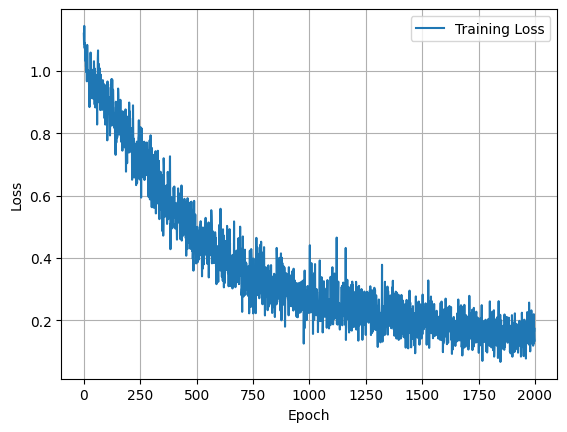

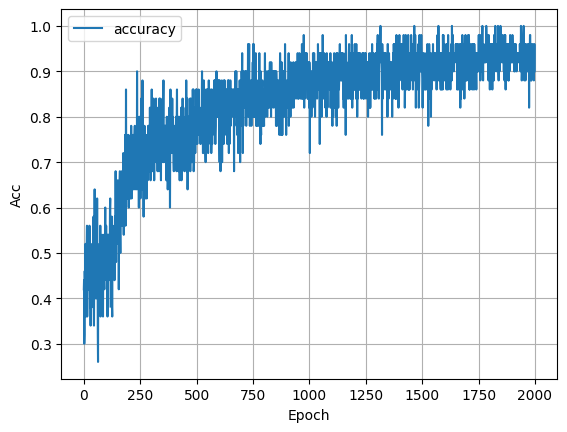

In [ ]:
# Plotting loss values
plt.figure()
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(acc_values, label="accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.grid()
plt.show()

# 참고

TensorDataset과 Dataloader 기능을 쓰면 더 쉽게 batch를 나누고 섞을 수 있다.

In [ ]:
# num_neurons의 값을 적절히 설정하고, num_classes 값은 Step 1에서 설정한 num_tendril 값과 동일하게 설정하여 초기화
model = Model(num_neurons=15, num_classes=num_tendril)

# batch_size 값을 50으로 설정(다른 값으로 해도 됨)
batch_size = 50

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# 학습 데이터와 라벨을 텐서로 변환
xtrain_tensor = torch.tensor(xtrain, dtype=torch.float32)
ytrain_tensor = torch.tensor(ytrain, dtype=torch.long)

# TensorDataset과 DataLoader를 사용하여 데이터셋 생성
train_dataset = TensorDataset(xtrain_tensor, ytrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 손실 값 저장
loss_values = []
acc_values = []
# 학습률 결정
lr = 0.1

for epoch_cnt in range(1000):
    for batch, truth in train_loader:
        # 은닉층부터 출력층의 가중치 곱까지의 순전파에서 전달되는 값 구하기
        prediction = model(batch)

        # 출력층의 활성함수와 결합된 손실함수 값 구하기, cross_entropy 함수 활용
        loss = F.cross_entropy(prediction, truth)

        # 기울기 초기화
        model.zero_grad()

        # torch의 자동미분 함수를 활용하여 역전파 진행
        loss.backward()

        # grad_descent 함수를 이용하여 경사하강의 한 스텝 진행
        grad_descent(model.parameters(), lr)

        # 정확도 계산, acc라는 이름으로 저장
        acc = accuracy(prediction, truth)

        # 손실 값과 정확도 저장
        loss_values.append(loss.detach().clone().numpy())
        acc_values.append(acc)

    print(f"Epoch {epoch_cnt+1}----------------------------")
    print(f"loss: {loss.item():.6f}")
    print(f"acc: {acc:.6f}")


Epoch 1----------------------------
loss: 1.135912
acc: 0.260000
Epoch 2----------------------------
loss: 1.054522
acc: 0.340000
Epoch 3----------------------------
loss: 1.049210
acc: 0.420000
Epoch 4----------------------------
loss: 1.054401
acc: 0.360000
Epoch 5----------------------------
loss: 1.060105
acc: 0.440000
Epoch 6----------------------------
loss: 0.955202
acc: 0.520000
Epoch 7----------------------------
loss: 1.000525
acc: 0.360000
Epoch 8----------------------------
loss: 1.021034
acc: 0.400000
Epoch 9----------------------------
loss: 0.937148
acc: 0.620000
Epoch 10----------------------------
loss: 0.978479
acc: 0.440000
Epoch 11----------------------------
loss: 0.923459
acc: 0.600000
Epoch 12----------------------------
loss: 1.005561
acc: 0.380000
Epoch 13----------------------------
loss: 0.997518
acc: 0.420000
Epoch 14----------------------------
loss: 0.935674
acc: 0.500000
Epoch 15----------------------------
loss: 0.922805
acc: 0.460000
Epoch 16-----------

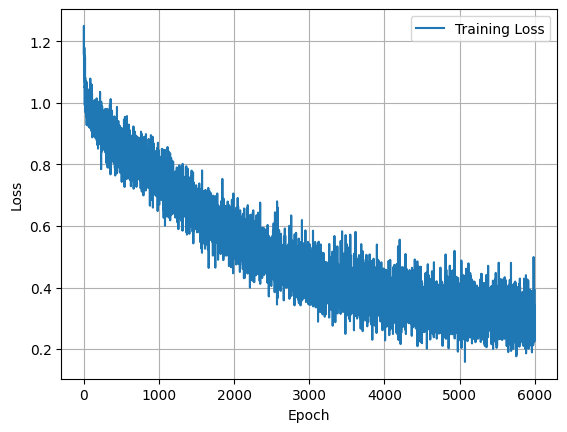

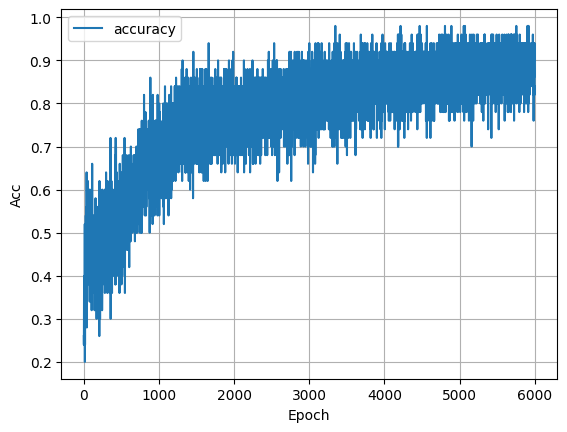

In [ ]:
# Plotting loss values
plt.figure()
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(acc_values, label="accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.grid()
plt.show()

# -

마지막으로, 학습을 종료한 후 아래의 코드를 그대로 실행시켜보자. 아래의 코드는 학습된 모델이 현재 어느 위치의 점을 어느 소용돌이에 속하는 것으로 분류하는지를 시각화한 그림을 그려주는 코드이다. 한 번 실행해보자.

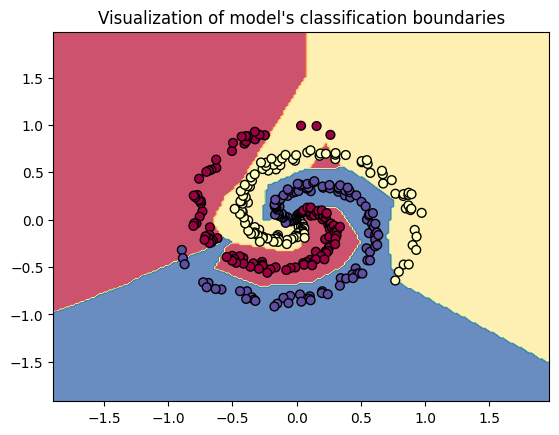

In [ ]:
def dummy_function(x):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    return F.softmax(model(x), dim=1).detach().numpy()

fig, ax = data.visualize_model(dummy_function, entropy=False);

학습을 잘 완료했다면, 대체적으로 점들이 속하는 소용돌이가 잘 구별되어지는 것을 확인할 수 있다. 한 가지의 특이한 점은, 소용돌이의 정보로 주어진 점들의 외부 영역에서는 소용돌이 모양으로 분류가 이어지지 않고 단순히 선형 형태로 영역이 구분되는 점이다. 이는 머신러닝이 주어진 데이터에만 기반하여 이루어졌음을 보여주고 있다. 외부 영역에 대해서는 모델의 평가가 이루어지지 않았기에 알 수 있는 정보가 없는 것이다. 마지막으로, 다양한 하이퍼파라미터 값을 조금씩 바꾸어보면서 코드를 여러 번 실행해보고, 학습 결과가 어떻게 달라지는지 생각해보자.

## 배운 내용 되돌아보기  
  
이번 실습에서는 실습 3-1에 이어, 신경망을 직접 설계 및 구현하고, 이를 학습시켜보았다. 그 결과, 점들로 이루어진 몇 개의 소용돌이가 주어지고, 새로운 점이 주어졌을 때 그 점이 속하는 소용돌이를 예상하는 문제를 해결해보았다. 처음에는 모델 파라미터를 랜덤하게 지정했음에도 불구하고, 학습을 거듭하다보면 마치 우리가 직관적으로 점이 속하는 소용돌이를 예상하는 효과를 내는 신경망은 매우 신비롭기도 하고, 한편으로는 데이터에 기반하여 갖는 한계를 보이기도 하였다. 이어지는 다음 실습에서는 이 문제에 다시 접근해볼 것이다. 지금까지는 경사하강 등을 직접 구현해왔지만, 이제 어느 정도 감을 잡았을테니 많이 사용되는 스킬을 한 번에 모아놓은 새로운 라이브러리, torch.nn을 소개하고 이를 활용하여 더 간편하게 신경망을 학습시켜볼 것이다. 그 전에, 이번 실습에서 배운 내용들을 한 번씩 되짚어보자.  
  
- 주어진 소용돌이를 구성하는 점들의 좌표를 제공받았고, 지도학습을 위한 새로운 점들의 좌표와 그것들이 속하는 소용돌이 정보를 데이터셋으로 받았다.
- 데이터셋을 학습용 데이터셋과 테스트용 데이터셋으로 나누었다.
- 입력층, 은닉층, 출력층으로 이루어지는 신경망을 구상해보았다.
- 분류(classification) 문제를 해결할 때는, 신경망의 출력은 주로 분류 결과의 가짓수만큼의 개수를 가짐을 배웠다. 이는 각 분류에 속할 가능성의 척도이다. 입력 데이터와 출력 데이터의 차원을 활용하여, 필요한 모델 파라미터의 차원을 결정하였다.
- 분류(classification) 문제를 해결할 때는 활성함수로 주로 ReLU 함수를 사용하는 것을 배웠고, 이 경우 모델 파라미터의 초기화에는 He Normal 초기화가 주로 사용됨을 배웠다.
- 학습을 위해 구성한 batch까지를 반영하여, 은닉층부터 출력층의 가중치 곱까지의 순전파 과정에서 일어나야 하는 연산을 수학적으로 설계하였고, 코딩을 통해 구현하였다.
- 은닉층과 출력층에 걸쳐 계산한 가능성 척도를 출력층의 활성함수로 사용한 소프트맥스 함수를 통해 확률과 유사하게 가공하였고, 손실함수로 교차 엔트로피 함수를 사용하여 모델을 평가하였다. 구현할 때는, 이 두 함수가 합쳐져 구현되어있는 torch 라이브러리의 cross_entropy 함수를 활용하였다.
- 모델의 직접적인 분류 정확도를 계산하기 위한 accuracy 함수를 설계하였다.
- 경사하강법을 통해 신경망을 학습시키며, 손실함수 값과 모델의 분류 정확도 값의 변화를 확인하였다.
- 최종적으로 학습된 모델이 어느 위치의 점을 어느 소용돌이에 속하는 것으로 분류하는지를 시각화하였고, 학습이 잘 이루어졌는지 확인하였다.